In [ ]:
#In this work, the 171 electrode's channels are considered as nodes, and edges are the respective connections.
#For the creation and study of complex networks, we used the package NetworkX.
#Each network is built considering the correlation of channel signals within time windows of 1 second. We focused on a more specific interval, from t=500s to t=1000s, that is 500 networks in total.
#Neural interactions have been assessed computing the Pearson correlation coefficient (Pcc), using the pearsonr function from the scipy.stats library.
#We performed the Bonferroni test, using the statsmodels.stats.multitest.multipletests function, in order to eliminate multiple spurious positives.  Once the corrected Pcc was calculated, we built the adjacency matrix (M).
#For each network we computed different centrality measures and we performed a Mann-Whitney U test, computing the normalized statistic for each measure to assess their effectiveness in distinguishing between epileptic and non-epileptic channels.

#In a parallel analysis, we used the Louvain algorithm to cluster the nodes in order to assess how distinctly the networks separated epileptic from non-epileptic channels. To measure the goodness of our clustering algorithm, we computed the v_measure_score which is a symmetric metric corresponding to the harmonic mean between homogeneity and completeness.
#We used this metric in order to evaluate:
#-how well the predicted clusters represent the epileptogenic and non-epileptogenic classes.
#-the connection between the predicted clusters and the electrodes. This should ideally be similar to the relationship between actual epileptogenic and non-epileptogenic classes and the electrodes.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import csv
from scipy.optimize import curve_fit
from scipy.fft import fft
from scipy import signal
from scipy.signal import iirnotch, lfilter
from scipy.signal import butter, filtfilt
import os
import networkx as nx
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.multitest import multipletests
from scipy.signal import find_peaks
import statistics
from scipy.signal import peak_widths
from sklearn.metrics import mutual_info_score
import matplotlib.patches as mpatches
from scipy.signal import butter, lfilter
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import networkx as nx
from community import community_louvain
from networkx.algorithms import community
from matplotlib.colors import ListedColormap
from sklearn.metrics import homogeneity_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import v_measure_score
from scipy.stats import mannwhitneyu, norm



In [4]:
#GRAPHIC SETTINGS
sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rcParams['lines.linewidth'] = 0.5
plt.rc('font', size=13)          # controls default text sizes


def divide_in_seconds(data, sample_rate):
    samples_per_second = sample_rate
    # Divido ciascun array in sottoliste di 'samples_per_second' elementi
    divided_data = [data[i:i+samples_per_second] for i in range(0, len(data), samples_per_second)]

    return divided_data

# Funzione per salvare ogni array in un file CSV separato
def save_arrays_to_csv(arrays,file_name,folder):
    csv_file_name = f'{folder}/{file_name}.csv'   
    with open(csv_file_name, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([file_name])
            writer.writerows([[value] for value in arrays[0:]])


In [5]:
folder_path_0 = 'dati_finali_NON_EPI'
folder_path_1 = 'dati_finali_EPI'
folder_path_freq = 'freq'

NON_EPI = []
NON_EPIcsv = []
EPI = []
EPIcsv = []
labels_0 = []
labels_1 = []

filenames_0 = [f for f in os.listdir(folder_path_0) if os.path.isfile(os.path.join(folder_path_0, f))]
filenames_1 = [f for f in os.listdir(folder_path_1) if os.path.isfile(os.path.join(folder_path_1, f))]

for filename_0 in filenames_0:
    file_path_0 = os.path.join(folder_path_0, filename_0)
    df_0 = pd.read_csv(file_path_0)
    NON_EPIcsv.append(df_0)
    labels_0.append(df_0.columns[0])
    for col_0 in df_0.columns:
        array_0 = df_0[col_0].values
        NON_EPI.append(array_0)
        
for filename_1 in filenames_1:
    file_path_1 = os.path.join(folder_path_1, filename_1)
    df_1 = pd.read_csv(file_path_1)
    EPIcsv.append(df_1)
    labels_1.append(df_1.columns[0])
    for col_1 in df_1.columns:
        array_1 = df_1[col_1].values
        EPI.append(array_1)


data_unsorted=NON_EPI+EPI
labels=labels_0+labels_1

combined = list(zip(labels, data_unsorted))
combined_sorted = sorted(combined, key=lambda x: x[0])
labels_tot, data = zip(*combined_sorted)
labels_tot = list(labels_tot)
data = list(data)


cartella = "time_domain_network_output(1s)"
os.makedirs(cartella, exist_ok=True)


In [6]:
divided_data = []
n=500 #Numero di valori dentro ad ogni sottogruppo (500 significa che divido in intervalli di 1s)
sec=n/500
Fs = 500.0
Ts = 1.0/Fs
l=len(data[0])
t = np.arange(l) * Ts
len_data_array=len(data[0])
print("Intervalli temporali di",sec, "s")
print("numero di misure per ogni canale (istanti di tempo):",len_data_array)
intervals_max=int(len_data_array/n) #max intervalli temporali che posso considerare
print("max intervalli temporali che posso considerare:",intervals_max)

for array in data:
    divided_d = divide_in_seconds(array, n)
    divided_data.append(divided_d)
#     fft_f,fft_a=calculate_fft(divided_d)
#     divided_fft.append(fft_a)

divided_time=divide_in_seconds(t, n)

# 'divided_arrays'è la lista di array divisi in intervalli di un secondo
first_interval_data= [array[0] for array in divided_data]  # Prendiamo i dati del primo intervallo temporale
n_channels=len(divided_data)
print(t[-1])
print(divided_time[len(divided_time)-1][-1])


Intervalli temporali di 1.0 s
numero di misure per ogni canale (istanti di tempo): 750000
max intervalli temporali che posso considerare: 1500
1499.998
1499.998


In [ ]:
p_values_all = []  
adjacency_matrices = [] 
Gs=[]
i1=intervals_max//3
i2=intervals_max*2//3
my_range=list(range(i1,i2))
for interval in my_range:  
    interval_data = [array[interval] for array in divided_data]  
    correlations = []
    p_values = []
    for i in range(len(interval_data)):
        for j in range(i+1, len(interval_data)):
            corr, p = pearsonr(interval_data[i], interval_data[j])
            correlations.append(corr)
            p_values.append(p)

    num_tests = len(p_values)
    N = n_channels
    alpha_corr=0.05*num_tests*2/(N*(N-1))
    reject, corrected_p_values, _, alpha_2 = multipletests(p_values, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    adjacency_matrix = np.zeros((len(interval_data),len(interval_data)))
    k = 0
    for i in range(len(interval_data)):
        for j in range(i+1, len(interval_data)):
            if reject[k]:  # Se la correlazione è significativa
                adjacency_matrix[i, j] = correlations[k]
                adjacency_matrix[j, i] = correlations[k]
            k += 1

    p_values_all.append(corrected_p_values)
    adjacency_matrices.append(adjacency_matrix)

    G = nx.from_numpy_array(adjacency_matrix)
    labels_dict = {i: label for i, label in enumerate(labels_tot)}
    nx.set_node_attributes(G, labels_dict, 'label')
    Gs.append(G)

os.makedirs("adjacency_matrices", exist_ok=True)
np.save("adjacency_matrices/adjacency_matrices_1s.npy", adjacency_matrices)

In [7]:
#CARICO LE MATRICI DI ADIACENZA SALVATE
adjacency_matrices = np.load("adjacency_matrices/adjacency_matrices_1s.npy", allow_pickle=True)
adjacency_matrices_list = adjacency_matrices.tolist()

In [8]:
labels_true = [0] * len(labels_tot)
for i, label in enumerate(labels_tot):
    if label in labels_1:
        labels_true[i] = 1


# Dizionario che associa ogni lettera a un numero
letter_to_number = {
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5,
    'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10,
    'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
    'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20,
    'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26
}
# Creazione del nuovo array con i numeri corrispondenti
labels_electrodes = [letter_to_number[label[0].upper()] for label in labels_tot]

print(labels_electrodes)
print(labels_true)
i1=intervals_max//3
i2=intervals_max*2//3
my_range=list(range(i1,i2))
labels_dict = {i: label for i, label in enumerate(labels_tot)}

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [9]:
partitions=[]
partitions_labels=[]
Gs=[]
centrality_measures=[]
i1=intervals_max//3
i2=intervals_max*2//3
my_range=list(range(i1,i2))

for interval, matrix in zip(my_range, adjacency_matrices):
    new_matrix = matrix
    new_matrix[new_matrix < 0] = 0
    G = nx.from_numpy_array(new_matrix)
    nx.set_node_attributes(G, labels_dict, 'label')
    Gs.append(G)

centrality_values = {}
for G in Gs:
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    local_clustering = nx.clustering(G)

    for node in G.nodes():
            label = G.nodes[node]['label']
            if label not in centrality_values:
                centrality_values[label] = {'Degree': [], 'Betweenness': [], 'Closeness': [], 'Local clustering': []}    
            centrality_values[label]['Degree'].append(degree_centrality[node])
            centrality_values[label]['Betweenness'].append(betweenness_centrality[node])
            centrality_values[label]['Closeness'].append(closeness_centrality[node])
            centrality_values[label]['Local clustering'].append(local_clustering[node])
    
# Calcolo la media dei valori di centralità per ogni etichetta
average_centrality = {}
for label, values in centrality_values.items():
    average_centrality[label] = {
        'Degree': sum(values['Degree']) / len(values['Degree']),
        'Betweenness': sum(values['Betweenness']) / len(values['Betweenness']),
        'Closeness': sum(values['Closeness']) / len(values['Closeness']),
        'Local clustering': sum(values['Local clustering']) / len(values['Local clustering'])
    }


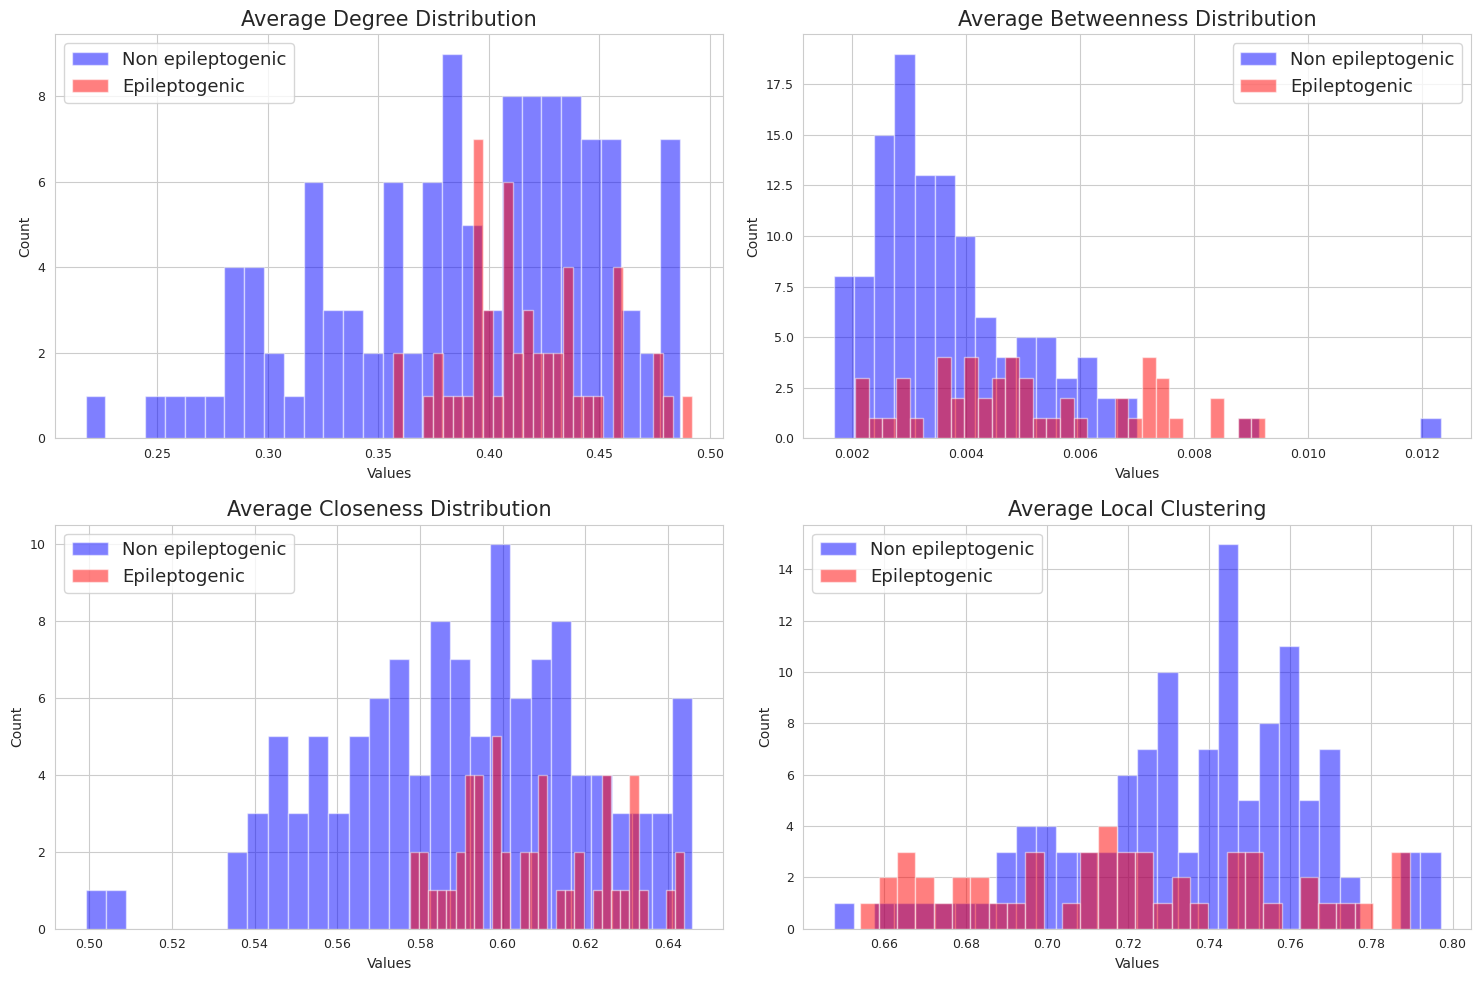

Betweenness   U Statistic: 0.27154391168232, p-value: 2.4409893322874045e-06
Le due distribuzioni sono significativamente diverse.
Closeness   U Statistic: 0.3346515076618883, p-value: 0.0006481237322496306
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.
Degree   U Statistic: 0.39149777558082055, p-value: 0.025254739275980542
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.
Local Clustering   U Statistic: 0.652496292634701, normalized p-value: 0.0016586050484489565
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.


In [10]:
df = pd.DataFrame.from_dict(average_centrality, orient='index')
df.reset_index(inplace=True)
df.columns = ['Label', 'Average Degree', 'Average Betweenness', 'Average Closeness','Average Local Clustering']

# Filtro i dati per label_0 e label_1
df_label_0 = df[df['Label'].isin(labels_0)]
df_label_1 = df[df['Label'].isin(labels_1)]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Degree Distribution
axs[0, 0].hist(df_label_0['Average Degree'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 0].hist(df_label_1['Average Degree'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 0].set_title('Average Degree Distribution')
axs[0, 0].set_xlabel('Values')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend()

# Betweenness Distribution
axs[0, 1].hist(df_label_0['Average Betweenness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 1].hist(df_label_1['Average Betweenness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 1].set_title('Average Betweenness Distribution')
axs[0, 1].set_xlabel('Values')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend()

# Closeness Distribution
axs[1, 0].hist(df_label_0['Average Closeness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 0].hist(df_label_1['Average Closeness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 0].set_title('Average Closeness Distribution')
axs[1, 0].set_xlabel('Values')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend()

# Distribuzione combinata di Degree, Betweenness e Closeness
axs[1, 1].hist(df_label_0['Average Local Clustering'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 1].hist(df_label_1['Average Local Clustering'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 1].set_title('Average Local Clustering')
axs[1, 1].set_xlabel('Values')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend()

plt.tight_layout()


nome_file=f'plots_mean_centrality_measures(1s).jpg'
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()



#------------------------------------------------


n1 = len(df_label_0['Average Local Clustering'])
n2 = len(df_label_1['Average Local Clustering'])

u_stat_b, p_value_b = mannwhitneyu(df_label_0['Average Betweenness'], df_label_1['Average Betweenness'])
u_statistic_normalized_b=u_stat_b/(n1*n2)
print(f"Betweenness   U Statistic: {u_statistic_normalized_b}, p-value: {p_value_b}")
if u_statistic_normalized_b < 0.3 or u_statistic_normalized_b>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")
    
u_stat_c, p_value_c = mannwhitneyu(df_label_0['Average Closeness'], df_label_1['Average Closeness'])
u_statistic_normalized_c=u_stat_c/(n1*n2)
print(f"Closeness   U Statistic: {u_statistic_normalized_c}, p-value: {p_value_c}")
if u_statistic_normalized_c < 0.3 or u_statistic_normalized_c>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")
    
u_stat_s, p_value_s = mannwhitneyu(df_label_0['Average Degree'], df_label_1['Average Degree'])
u_statistic_normalized_s=u_stat_s/(n1*n2)
print(f"Degree   U Statistic: {u_statistic_normalized_s}, p-value: {p_value_s}")
if u_statistic_normalized_s < 0.3 or u_statistic_normalized_s>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")

u_stat_cl, p_value_cl = mannwhitneyu(df_label_0['Average Local Clustering'], df_label_1['Average Local Clustering'])
u_statistic_normalized_cl=u_stat_cl/(n1*n2)
print(f"Local Clustering   U Statistic: {u_statistic_normalized_cl}, normalized p-value: {p_value_cl}")
if u_statistic_normalized_cl < 0.3 or u_statistic_normalized_cl>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")





In [11]:
average_centrality_significative = {}
for label, values in centrality_values.items():
    average_centrality_significative[label] = {
        'Degree': sum(values['Degree']) / len(values['Degree']),
        'Betweenness': sum(values['Betweenness']) / len(values['Betweenness']),
        'Closeness': sum(values['Closeness']) / len(values['Closeness'])
    }

# Salvataggio del DataFrame in un file CSV
df_ok = pd.DataFrame.from_dict(average_centrality_significative, orient='index')
df_ok.reset_index(inplace=True)
df_ok.columns = ['Label', 'Average Degree (1s intervals mean)', 'Average Betweenness (1s intervals mean)', 'Average Closeness (1s intervals mean)',]
print(df_ok)

filename = f"time_1s.csv"
percorso_completo = os.path.join(cartella, filename)
df_ok.to_csv(percorso_completo, index=False)

    Label  Average Degree (1s intervals mean)  \
0      A1                            0.485822   
1     A10                            0.432213   
2     A11                            0.417929   
3     A12                            0.443870   
4     A13                            0.452189   
..    ...                                 ...   
165    Z2                            0.430071   
166    Z3                            0.399314   
167    Z4                            0.411030   
168    Z5                            0.386130   
169    Z6                            0.374627   

     Average Betweenness (1s intervals mean)  \
0                                   0.005554   
1                                   0.003651   
2                                   0.003776   
3                                   0.003918   
4                                   0.003928   
..                                       ...   
165                                 0.009244   
166                        

# Clustering

In [12]:
partitions=[]
partitions_labels=[]
Gs=[]
homogeneity_scores1 = []
homogeneity_scores2 = []
homogeneity_scores3 = []
ari_scores1 = []
ari_scores2 = []
ari_scores3 = []
v_scores1 = []
v_scores2 = []
v_scores3 = []
filtered_partitions=[]

for interval, matrix in zip(my_range, adjacency_matrices):
    min_time=interval
    max_time=interval+1
    print("intervallo temporale: da ",min_time,' s a',max_time,'s')
  
    #print("intervallo temporale: da ",min_time,' s a',max_time,'s')
    
    new_matrix = matrix
    new_matrix[new_matrix < 0] = 0
    G = nx.from_numpy_array(new_matrix)
    nx.set_node_attributes(G, labels_dict, 'label')
    Gs.append(G)
    
    partition = community_louvain.best_partition(G,resolution=0.6)
    # Filtro i cluster con meno di 5 elementi
    filtered_partition = {node: cluster_id for node, cluster_id in partition.items() if list(partition.values()).count(cluster_id) > 10}
    filtered_partitions.append(filtered_partition)
    
    cls = {}
    for node, cluster_id in filtered_partition.items():
        if cluster_id not in cls:
            cls[cluster_id] = []
        cls[cluster_id].append((node, labels_tot[node]))
    
    non_clustered_nodes = [node for node in partition if node not in filtered_partition]
    clustered_nodes = [node for node in partition if node in filtered_partition]

    labels_pred = [f"{filtered_partition[node]}" for node in range(len(labels_tot)) if node in filtered_partition]
    num_clusters = len(cls)
    print(f"Numero di cluster: {num_clusters}")

    #-------------------------------------V-MEASURE----------------------------------------

    labels_true_filtered = [labels_true[node] for node in clustered_nodes]
    labels_electrodes_less = [labels_electrodes[node] for node in clustered_nodes]

    if len(non_clustered_nodes)<70:
        # CLASSI EPI-NON EPI vs CLUISTERS
        v_score1= v_measure_score(labels_true_filtered, labels_pred)
        #print(f'V Score classes vs clusters: {v_score1:.3f}')
        v_scores1.append(v_score1) 
    
        #CLASSI ELETTRODI VS EPI-NON EPI 
        v_score2= v_measure_score( labels_true,labels_electrodes)
        # print(f'V Score electrodes vs epi/non epi: {v_score2:.3f}')
        v_scores2.append(v_score2) 
    
    
        #CLASSI ELETTRODI VS CLUSTERS
        v_score3= v_measure_score(labels_pred,labels_electrodes_less )
        # print(f'V Score electrodes vs clusters: {v_score3:.3f}')
        v_scores3.append(v_score3) 
    else:
        v_scores1.append(0) 
        v_scores2.append(0) 
        v_scores3.append(0) 

mean_v1=np.mean(v_scores1)
mean_v2=np.mean(v_scores2)
mean_v3=np.mean(v_scores3)
print(f'V Score classes vs clusters: {mean_v1:.3f}')
print(f'V Score classes vs el: {mean_v2:.3f}')
print(f'V Score cluster vs el: {mean_v3:.3f}')


intervallo temporale: da  500  s a 501 s
Numero di cluster: 3
intervallo temporale: da  501  s a 502 s
Numero di cluster: 3
intervallo temporale: da  502  s a 503 s
Numero di cluster: 2
intervallo temporale: da  503  s a 504 s
Numero di cluster: 4
intervallo temporale: da  504  s a 505 s
Numero di cluster: 4
intervallo temporale: da  505  s a 506 s
Numero di cluster: 2
intervallo temporale: da  506  s a 507 s
Numero di cluster: 3
intervallo temporale: da  507  s a 508 s
Numero di cluster: 4
intervallo temporale: da  508  s a 509 s
Numero di cluster: 2
intervallo temporale: da  509  s a 510 s
Numero di cluster: 3
intervallo temporale: da  510  s a 511 s
Numero di cluster: 3
intervallo temporale: da  511  s a 512 s
Numero di cluster: 3
intervallo temporale: da  512  s a 513 s
Numero di cluster: 3
intervallo temporale: da  513  s a 514 s
Numero di cluster: 3
intervallo temporale: da  514  s a 515 s
Numero di cluster: 2
intervallo temporale: da  515  s a 516 s
Numero di cluster: 2
interval

500


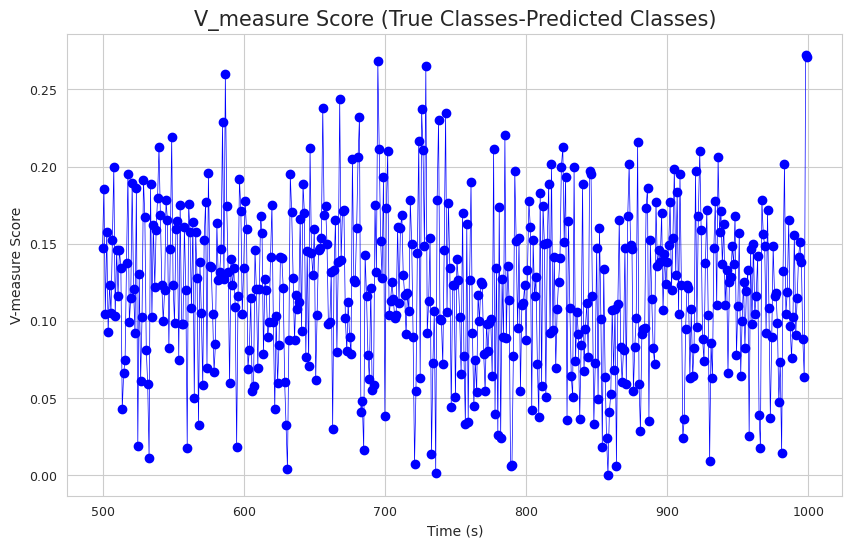

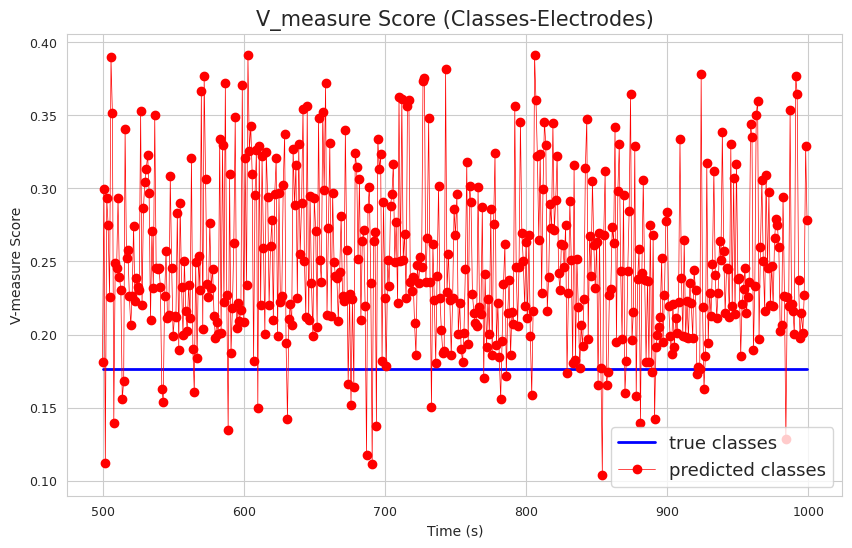

     Time interval (10 s)  classes 01 vs clusters  electrodes vs classes 01  \
0                     500                0.147403                  0.176184   
1                     501                0.185751                  0.176184   
2                     502                0.104196                  0.176184   
3                     503                0.157644                  0.176184   
4                     504                0.092471                  0.176184   
..                    ...                     ...                       ...   
495                   995                0.138273                  0.176184   
496                   996                0.088082                  0.176184   
497                   997                0.063664                  0.176184   
498                   998                0.272495                  0.176184   
499                   999                0.271170                  0.176184   

     electrodes vs clusters  
0                  0.

In [13]:
time = my_range
print(len(time))

#--------------------------------V MEASURE----------------------
plt.figure(figsize=(10, 6))
plt.plot(time, v_scores1, marker='o', linestyle='-', color='b')

# Aggiungi titoli e etichette agli assi
plt.title('V_measure Score (True Classes-Predicted Classes)')
plt.xlabel('Time (s)')
plt.ylabel('V-measure Score')
plt.grid(True)
nome_file = f"v_score(classes-clusters)_({time[0]}-{time[-1]} s).jpg"
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(time, v_scores2, linestyle='-',linewidth=2, color='b',label='true classes')
plt.plot(time, v_scores3, marker='o', linestyle='-', color='r',label='predicted classes')
plt.legend()
plt.title('V_measure Score (Classes-Electrodes)')
plt.xlabel('Time (s)')
plt.ylabel('V-measure Score')
plt.grid(True)

nome_file=f"v(electrodes)_({time[0]}-{time[-1]} s).jpg"
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()

data = {
    "Time interval (10 s)": time,
    "classes 01 vs clusters": v_scores1,
    "electrodes vs classes 01": v_scores2,
    "electrodes vs clusters": v_scores3
}

df = pd.DataFrame(data)

# Salvataggio del DataFrame in un file CSV
filename = f"v_scores ({time[0]}-{time[-1]} s).csv"
percorso_completo = os.path.join(cartella, filename)
df.to_csv(percorso_completo, index=False)

print(df)





In [26]:
max_value = max(v_scores1)
max_position = v_scores1.index(max_value)

print(f"Valore massimo: {max_value}")
print(f"Posizione: {max_position}")
print(f"Intervallo temporale: {my_range[max_position]}-{my_range[max_position+1]} s")

Valore massimo: 0.3158960081890938
Posizione: 243
Intervallo temporale: 743-744 s


Nodi non compresi in nessun cluster di filtered_partition 0: []
Nodi compresi nei cluster di filtered_partition 170:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169]
Numero di cluster: 3


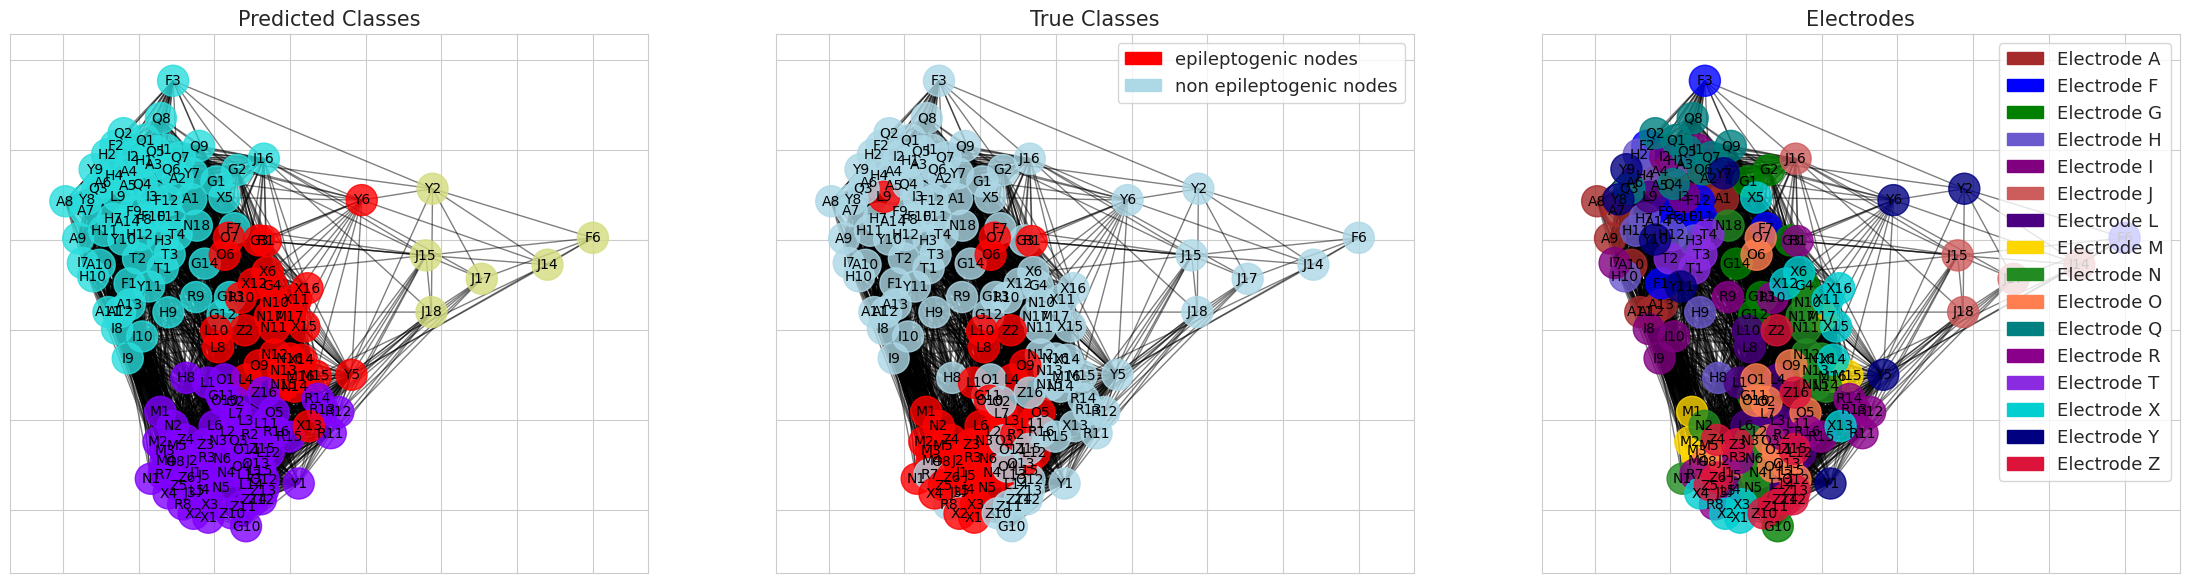

In [27]:
G_max=Gs[max_position]
filtered_partition = filtered_partitions[max_position]

cls = {}
for node, cluster_id in filtered_partition.items():
    if cluster_id not in cls:
        cls[cluster_id] = []
    cls[cluster_id].append((node, labels_tot[node]))

non_clustered_nodes = [node for node in partition if node not in filtered_partition]
clustered_nodes = [node for node in partition if node in filtered_partition]

print(f"Nodi non compresi in nessun cluster di filtered_partition {len(non_clustered_nodes)}: {non_clustered_nodes}")
print(f"Nodi compresi nei cluster di filtered_partition {len(clustered_nodes)}:{clustered_nodes}")
# for node in non_clustered_nodes:
#     print(non_clustered_nodes)
#     print(labels_tot[node])
 
labels_pred = [f"{filtered_partition[node]}" for node in range(len(labels_tot)) if node in filtered_partition]
num_clusters = len(cls)
print(f"Numero di cluster: {num_clusters}")
#--------------------------------------GRAFICI---------------------------------------------

plt.figure(figsize=(28, 7))
seed_value = 42
pos = nx.spring_layout(G, seed=seed_value)

# Assegno un colore a ciascun cluster
plt.subplot(131) 
colors = [partition[node] for node in range(len(labels_tot))]
nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.rainbow, node_color=colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10)
plt.title('Predicted Classes')

# Assegno un colore diverso alle due classi 0 e 1
plt.subplot(132) 
node_colors2 = []
for label in labels_tot:
    if label in labels_0:
        node_colors2.append('lightblue')
    elif label in labels_1:
        node_colors2.append('red')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors2, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10)
epileptogenic_patch = mpatches.Patch(color='red', label='epileptogenic nodes')
non_epileptogenic_patch = mpatches.Patch(color='lightblue', label='non epileptogenic nodes')
plt.legend(handles=[epileptogenic_patch, non_epileptogenic_patch], loc='upper right')
plt.title('True Classes')

# Assegno un colore a ciascun elettrodo
plt.subplot(133) 
colors = {'A': 'brown', 'F': 'blue', 'G': 'green', 'H': 'slateblue', 'I': 'purple', 'J': 'indianred', 'L': 'indigo', 'M': 'gold',
          'N': 'forestgreen', 'O': 'coral', 'Q': 'teal', 'R': 'darkmagenta', 'T': 'blueviolet', 'X': 'darkturquoise', 'Y': 'navy', 'Z': 'crimson'}
labels = labels_tot
node_colors = [colors[label[0].upper()] if label[0].upper() in colors else 'white' for label in labels]
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10,font_color='black')
legend_elements = [mpatches.Patch(color=color, label='Electrode ' + letter) for letter, color in colors.items()]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Electrodes')


max1=500+max_position
max2=500+max_position+1
nome_file=f'plots_max_homogeneity_time_({max1}-{max2}s).jpg'
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()

print()


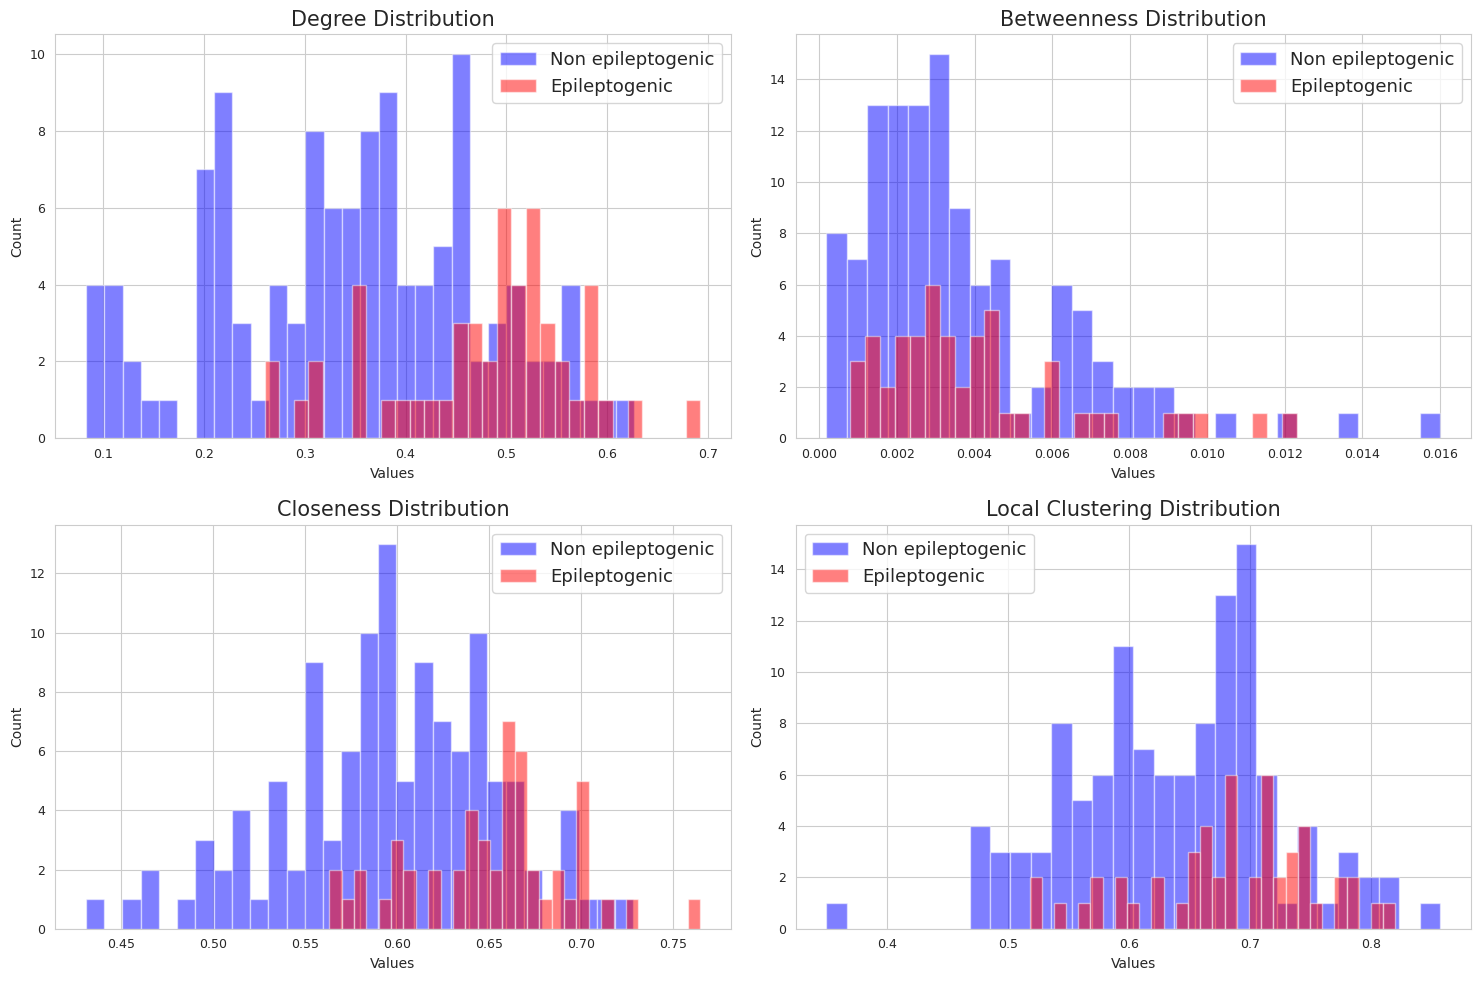

Betweenness   U Statistic: 0.4486735870818916, p-value: 0.29026789137335085
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.
Closeness   U Statistic: 0.21980556928653813, p-value: 7.386852991946133e-09
Le due distribuzioni sono significativamente diverse.
Degree   U Statistic: 0.206788597792058, p-value: 1.444551910833511e-09
Le due distribuzioni sono significativamente diverse.
Local Clustering   U Statistic: 0.3344867358708189, normalized p-value: 0.0006400833773249703
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.


In [28]:

#----------------------------MISURE DI CENTRALITA'------------------------------
degree_centrality = nx.degree_centrality(G_max)
betweenness_centrality = nx.betweenness_centrality(G_max)
closeness_centrality = nx.closeness_centrality(G_max)
local_clustering = nx.clustering(G_max)

data = []
for node in G_max.nodes():
    label = G_max.nodes[node]['label']
    degree = degree_centrality[node]
    betweenness = betweenness_centrality[node]
    closeness = closeness_centrality[node]
    local_cl = local_clustering[node]
    data.append([node, label, degree, betweenness, closeness,local_cl])

df = pd.DataFrame(data, columns=['Nodo', 'Label', 'Degree', 'Betweenness', 'Closeness','Local Clustering'])

# Filtro i dati per label_0 e label_1
df_label_0 = df[df['Label'].isin(labels_0)]
df_label_1 = df[df['Label'].isin(labels_1)]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Degree Distribution
axs[0, 0].hist(df_label_0['Degree'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 0].hist(df_label_1['Degree'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 0].set_title('Degree Distribution')
axs[0, 0].set_xlabel('Values')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend()

# Betweenness Distribution
axs[0, 1].hist(df_label_0['Betweenness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 1].hist(df_label_1['Betweenness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 1].set_title('Betweenness Distribution')
axs[0, 1].set_xlabel('Values')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend()

# Closeness Distribution
axs[1, 0].hist(df_label_0['Closeness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 0].hist(df_label_1['Closeness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 0].set_title('Closeness Distribution')
axs[1, 0].set_xlabel('Values')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend()

# Distribuzione combinata di Degree, Betweenness e Closeness
axs[1, 1].hist(df_label_0['Local Clustering'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 1].hist(df_label_1['Local Clustering'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 1].set_title('Local Clustering Distribution')
axs[1, 1].set_xlabel('Values')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend()

plt.tight_layout()
nome_file=f'plots_max_v-score_centrality_measures(1s).jpg'
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()


#-----------------------------------------------------


n1 = len(df_label_0['Local Clustering'])
n2 = len(df_label_1['Local Clustering'])

u_stat_b, p_value_b = mannwhitneyu(df_label_0['Betweenness'], df_label_1['Betweenness'])
u_statistic_normalized_b=u_stat_b/(n1*n2)
print(f"Betweenness   U Statistic: {u_statistic_normalized_b}, p-value: {p_value_b}")
if u_statistic_normalized_b < 0.3 or u_statistic_normalized_b>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")
    
u_stat_c, p_value_c = mannwhitneyu(df_label_0['Closeness'], df_label_1['Closeness'])
u_statistic_normalized_c=u_stat_c/(n1*n2)
print(f"Closeness   U Statistic: {u_statistic_normalized_c}, p-value: {p_value_c}")
if u_statistic_normalized_c < 0.3 or u_statistic_normalized_c>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")
    
u_stat_s, p_value_s = mannwhitneyu(df_label_0['Degree'], df_label_1['Degree'])
u_statistic_normalized_s=u_stat_s/(n1*n2)
print(f"Degree   U Statistic: {u_statistic_normalized_s}, p-value: {p_value_s}")
if u_statistic_normalized_s < 0.3 or u_statistic_normalized_s>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")

u_stat_cl, p_value_cl = mannwhitneyu(df_label_0['Local Clustering'], df_label_1['Local Clustering'])
u_statistic_normalized_cl=u_stat_cl/(n1*n2)
print(f"Local Clustering   U Statistic: {u_statistic_normalized_cl}, normalized p-value: {p_value_cl}")
if u_statistic_normalized_cl < 0.3 or u_statistic_normalized_cl>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")


In [15]:
# Salvataggio del DataFrame in un file CSV
filename = f"Max_v-score_central measures_1s.csv"
percorso_completo = os.path.join(cartella, filename)
df.to_csv(percorso_completo, index=False)